In [3]:
import keras
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from utils.sentence_processor import SentenceProcessor
from sklearn.metrics import mean_squared_error

In [4]:
with open('data/dataset_internet_full+train+test.npz', 'rb') as f:
    X_train_final = np.load(f)
    y_train_final = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)

# Модель №2
**Вход**

**Данные:** Объединение обучающей выборки и отзывов об интернет-провайдерах, взятые с сайта: moskvaonline.ru. Отзывы ограничены 100 словами

**Представление:** word2vec на основе обученной модели gensim, размерность пространства: 500

**Описание модели:** 4 параллельные 1D свертки с разым размером окна по компоненте word2vec, с L2 регулиризацией, max pooling после каждой свертки, далее объединение результатов и один полносвязный слой с дропаутом, далее выход регрессии.

**Параметры обучения:** Оптимизатор: стохастический градиентный спуск, learning rate опредлялся как: 2 эпохи с 0.01, далее ~5 эпох с 0.001, далее ~5 эпох с 0.0001, далее ~5 эпох с 0.00005

**Целевая метрика:** MSE

**Результат (целевые переменные не нормировались!):** MSE(train)=0.6199, MSE(test)=**0.9198**

#### Загрузка обучающей и тестовой выборки

In [4]:
reviews_test = pd.read_csv('data/reviews_test.csv', header=0, encoding='utf-8')
reviews_train = pd.read_csv('data/reviews_train.csv', header=0, encoding='utf-8')

X_train_raw = reviews_train.comment
y_train_raw = reviews_train.reting
X_test_raw = reviews_test.comment
y_test_raw = reviews_test.reting


#### Загрузка модели word2vec

In [2]:
DIR = 'data/w2v_models/'
MODEL_NAME = 'tenth.norm-sz500-w7-cb0-it5-min5.w2v'
VECTOR_SIZE = 500
SENTENCE_LENGTH = 100 #words

In [3]:
w2v_path = DIR + MODEL_NAME
sentence_processor = SentenceProcessor(w2v_path)

# words with wery high freqyency in comments
# garbage_list = ['я', 'большой', 'по', 'купить', 'этот', 'на', 'один', 'так', 'только', 'из', 'хороший', 'как', \
#                 'отличный', 'что', 'это', 'и', 'за', 'у', 'в', 'если', 'с', 'очень', 'нет', 'же', 'он', 'при', \
#                 'для', 'пользоваться', 'быть', 'а', 'просто', 'раз', 'работать', 'но', 'качество', 'к', 'весь',\
#                 'можно', 'есть', 'цена', 'от', 'уже', 'такой', 'она', 'год', 'то']

sentence_processor.stop_list = []

#### Подготовка данных: перевод в матрицу, размером: "количество отзывов" х "количество слов в отзыве (обрезано или дополнено до 100)" х "размерность word2vec"

In [10]:
X_train = []
y_train = []

for i in tqdm(range(len(X_train_raw))):
    sent = sentence_processor.process(X_train_raw[i])
    matrix = sentence_processor.convert2matrix(sent, sample_len=SENTENCE_LENGTH)
    if matrix.shape == (SENTENCE_LENGTH, VECTOR_SIZE):
        X_train.append(matrix)
        y_train.append(y_train_raw[i])

100%|██████████| 12410/12410 [08:09<00:00, 25.35it/s]


In [12]:
X_test = []
y_test = []
                       
for i in tqdm(range(len(X_test_raw))):
    sent = sentence_processor.process(X_test_raw[i])
    matrix = sentence_processor.convert2matrix(sent, sample_len=SENTENCE_LENGTH)
    if matrix.shape == (SENTENCE_LENGTH, VECTOR_SIZE):
        X_test.append(matrix)
        y_test.append(y_test_raw[i])

100%|██████████| 3103/3103 [02:03<00:00, 25.16it/s]


In [13]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [4]:
reviews_internet = pd.read_csv('data/internet_reviews.csv', header=0, encoding='utf-8')

X_reviews_internet = reviews_internet.comment
y_reviews_internet = reviews_internet.rating


In [5]:
X_reviews_internet_ = []
y_reviews_internet_ = []

for i in tqdm(range(len(X_reviews_internet))):
    sent = sentence_processor.process(X_reviews_internet[i])
    matrix = sentence_processor.convert2matrix(sent, sample_len=SENTENCE_LENGTH)
    if matrix.shape == (SENTENCE_LENGTH, VECTOR_SIZE):
        X_reviews_internet_.append(matrix)
        y_reviews_internet_.append(y_reviews_internet[i])

100%|██████████| 21713/21713 [45:10<00:00,  8.85it/s]  


In [6]:
X_reviews_internet_ = np.array(X_reviews_internet_, dtype=np.float32)
y_reviews_internet_ = np.array(y_reviews_internet_, dtype=np.float32)

In [5]:
X_train_final = np.concatenate((X_train, X_reviews_internet_), axis=0)
y_train_final = np.concatenate((y_train, y_reviews_internet_), axis=0)


## Обучение модели

In [5]:
from keras.models import Sequential
import keras
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LocallyConnected1D, Conv1D, Dropout
from keras.layers import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.preprocessing import sequence
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import Input, Dense


In [7]:
input_1 = Input(shape=(100,500))
conv_1 = Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.02))(input_1)
pool_1 = GlobalMaxPooling1D()(conv_1)

conv_2 = Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.02))(input_1)
pool_2 = GlobalMaxPooling1D()(conv_2)

conv_3 = Conv1D(filters=512, kernel_size=7, activation='relu', kernel_regularizer=regularizers.l2(0.02))(input_1)
pool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(filters=512, kernel_size=9, activation='relu', kernel_regularizer=regularizers.l2(0.02))(input_1)
pool_4 = GlobalMaxPooling1D()(conv_4)


concat_1 = concatenate([pool_1, pool_2, pool_3, pool_4], axis=1)

dense_1 = Dense(300, activation='relu')(concat_1)
drop_1 = Dropout(0.5)(dense_1)

dense_4 = Dense(1, activation=None)(drop_1)

model = Model(inputs=input_1, outputs=dense_4)

model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 100, 500)      0                                            
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 98, 256)       384256      input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_6 (Conv1D)                (None, 96, 256)       640256      input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_7 (Conv1D)                (None, 94, 512)       1792512     input_2[0][0]                    
___________________________________________________________________________________________

In [ ]:
sgd = SGD(lr=0.00005)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse'])

model.fit(X_train_final, y_train_final, batch_size=10, epochs=15, validation_data=(X_test, y_test), shuffle=True,
          verbose=True)

In [20]:
model.save('trained_model_2(keras==2.0.8)')

In [9]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def get_score(model, x, y, plot=True, sparse=50):
    
    y_pred = model.predict(x)  
    y_pred = np.clip(y_pred, 1.0, 5.0)
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    medae = median_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print ('{:.4} \nMSE: {:.4}\nMAE: {:.4}\nMedianAE: {:.4}\nR2 score: {:.4}'.format(model.name, mse, mae, medae, r2))
    
    if plot:
        plt.figure(figsize=(20,5))
        plt.title(model.name)
        plt.ylabel('Score')
        plt.plot(y_pred[::sparse])
        plt.plot(y[::sparse])
        plt.legend(('y_pred', 'y_test'))
        plt.show()
    
    return {'mean squared error':mse, 'mean absolute error':mae, 'median absolute error':medae, 'r2 score':r2}

# Результаты
Результаты на тестовой выборке (20% от исходных данных)

**целевые переменные не нормировались!**

mode 
MSE: 0.9058
MAE: 0.6832
MedianAE: 0.5121
R2 score: 0.4741


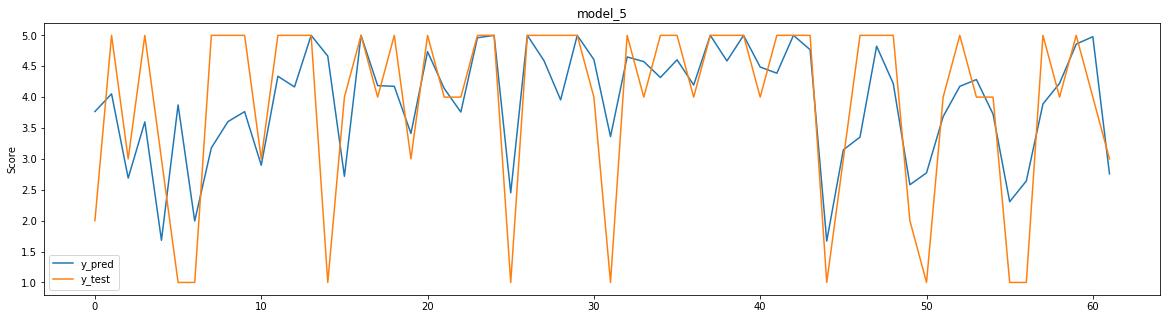

{'mean absolute error': 0.68315595,
 'mean squared error': 0.90583926,
 'median absolute error': 0.51206315,
 'r2 score': 0.47408166012846376}

In [17]:
get_score(model, X_test, y_test, sparse=50)